In [1]:
# Dalvin Colbert 
# D603 - Machine Learning
# Task 3 - Time Series Modeling

In [2]:

pip install numpy==1.26.4


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy==1.26.4 in c:\users\dalvi\anaconda3\lib\site-packages (1.26.4)



In [3]:
import numpy as np
print(np.__version__)


1.26.4


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import welch
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings 
warnings.filterwarnings('ignore')


In [5]:
df = pd.read_csv('C:\\Users\\dalvi\\OneDrive - Western Governors University\\MSDADS\\D603 - Machine Learning\\Writeup\\Task 3\\churn_clean.csv')
num_rows, num_columns = df.shape

# Describe the general characteristcs of the inital dataset (e.g., rows, columns)
print(f"The dataset contains {num_rows} rows and {num_columns} columns.")
print(f"The variables are {df.columns[0]} and {df.columns[1]}")

The dataset contains 731 rows and 2 columns.
The variables are Day and Revenue


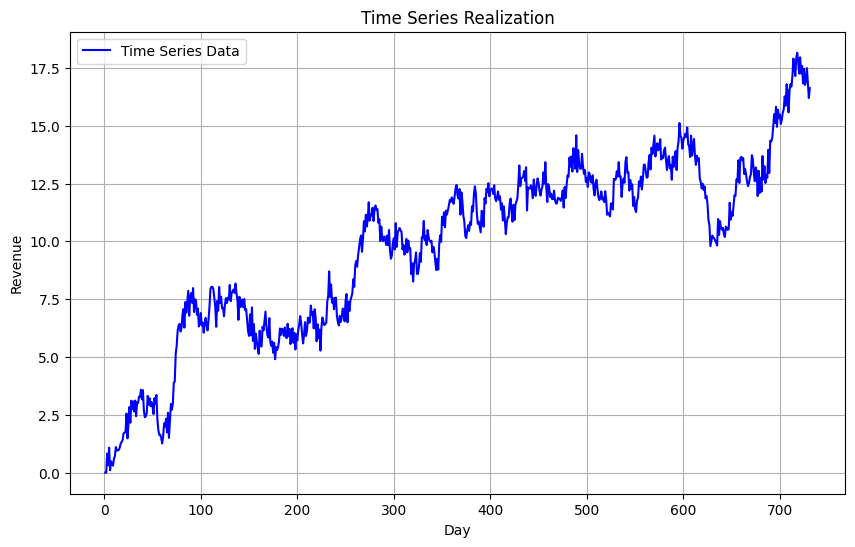

In [6]:
# Create a line graph visualizing the time series data
# Commit 1
plt.figure(figsize=(10, 6))
plt.plot(df['Day'], df['Revenue'], label='Time Series Data', color='blue')
plt.title('Time Series Realization')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Evaluate stationarity of the time series
def adf_test(timeseries):
    result = adfuller(timeseries, autolag="AIC")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(df['Revenue'])


ADF Statistic: -1.9246120613761046
p-value: 0.32057285950231795
Critical Values:
	1%: -3.4393520240470554
	5%: -2.8655128165959236
	10%: -2.5688855736949163


In [8]:
# Identify duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate entries: {duplicates}")
print("\n\n")

Number of duplicate entries: 0





In [9]:
# Missing values
total_missing_values = df.isna().sum().sum()
print('Total missing values: ', total_missing_values)
print(df.isna().sum())

Total missing values:  0
Day        0
Revenue    0
dtype: int64


In [10]:
# Find outliers
def find_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    out_array = np.where((data < lower_bound) | (data > upper_bound))
    return out_array    

find_outliers_iqr(df)

(array([], dtype=int64), array([], dtype=int64))

In [11]:
# Train and test w/ 80/20 split
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]
print(f"The train set dimensions are: {train_data.shape}")
print(f"The test set dimensions are: {test_data.shape}")

The train set dimensions are: (584, 2)
The test set dimensions are: (147, 2)


In [12]:
# Missing values
total_missing_values = train_data.isna().sum().sum()
print('Total missing values: ', total_missing_values)
print(df.isna().sum())

Total missing values:  0
Day        0
Revenue    0
dtype: int64


In [13]:
# Missing values
total_missing_values = test_data.isna().sum().sum()
print('Total missing values: ', total_missing_values)
print(df.isna().sum())

Total missing values:  0
Day        0
Revenue    0
dtype: int64


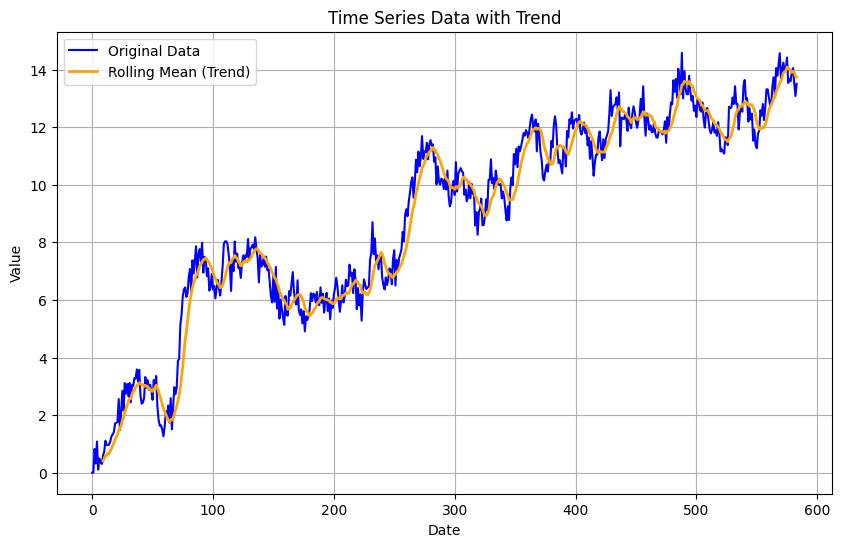

In [15]:
# Trend analysis

# Calculate rolling mean
rolling_mean = train_data['Revenue'].rolling(window=10).mean()

# Plot the original data and rolling mean
plt.figure(figsize=(10, 6))
plt.plot(train_data['Revenue'], label='Original Data', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (Trend)', color='orange', linewidth=2)
plt.title('Time Series Data with Trend')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


<Figure size 1000x600 with 0 Axes>

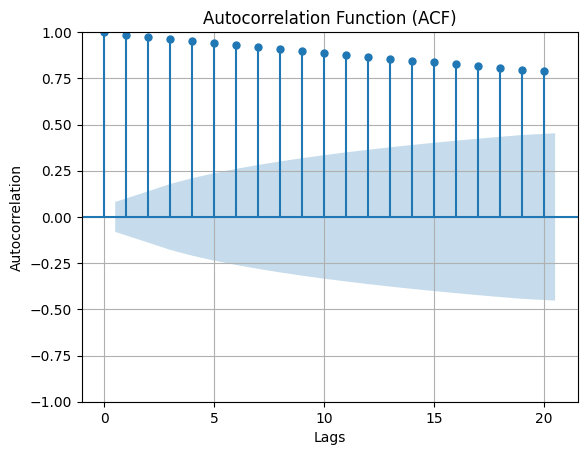

In [16]:


# Plot the autocorrelation function
plt.figure(figsize=(10, 6))
plot_acf(train_data['Revenue'], lags=20, alpha=0.05)  # lags=20 specifies up to 20 lags
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()


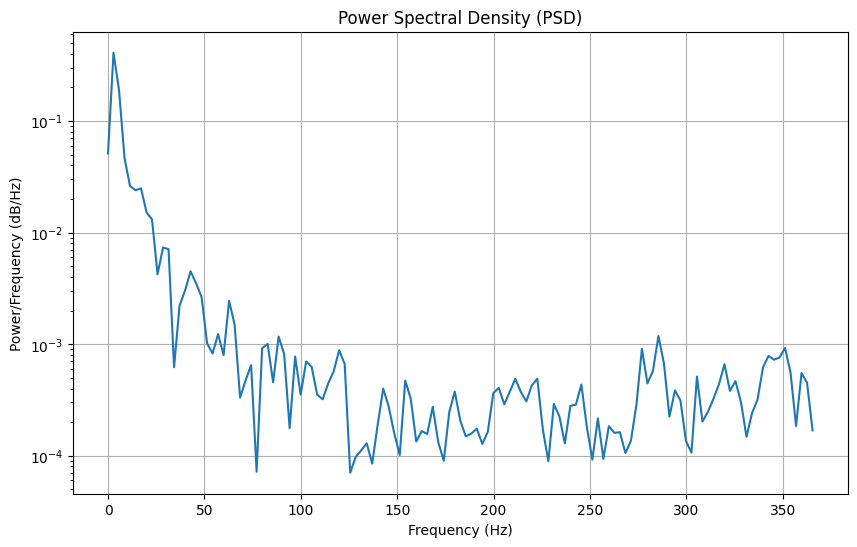

In [17]:
# Spectral Density
# Compute the Power Spectral Density (PSD) using Welch's method
frequencies, psd = welch(train_data['Revenue'], fs=731, nperseg=256)

# Plot the PSD
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid()
plt.show()


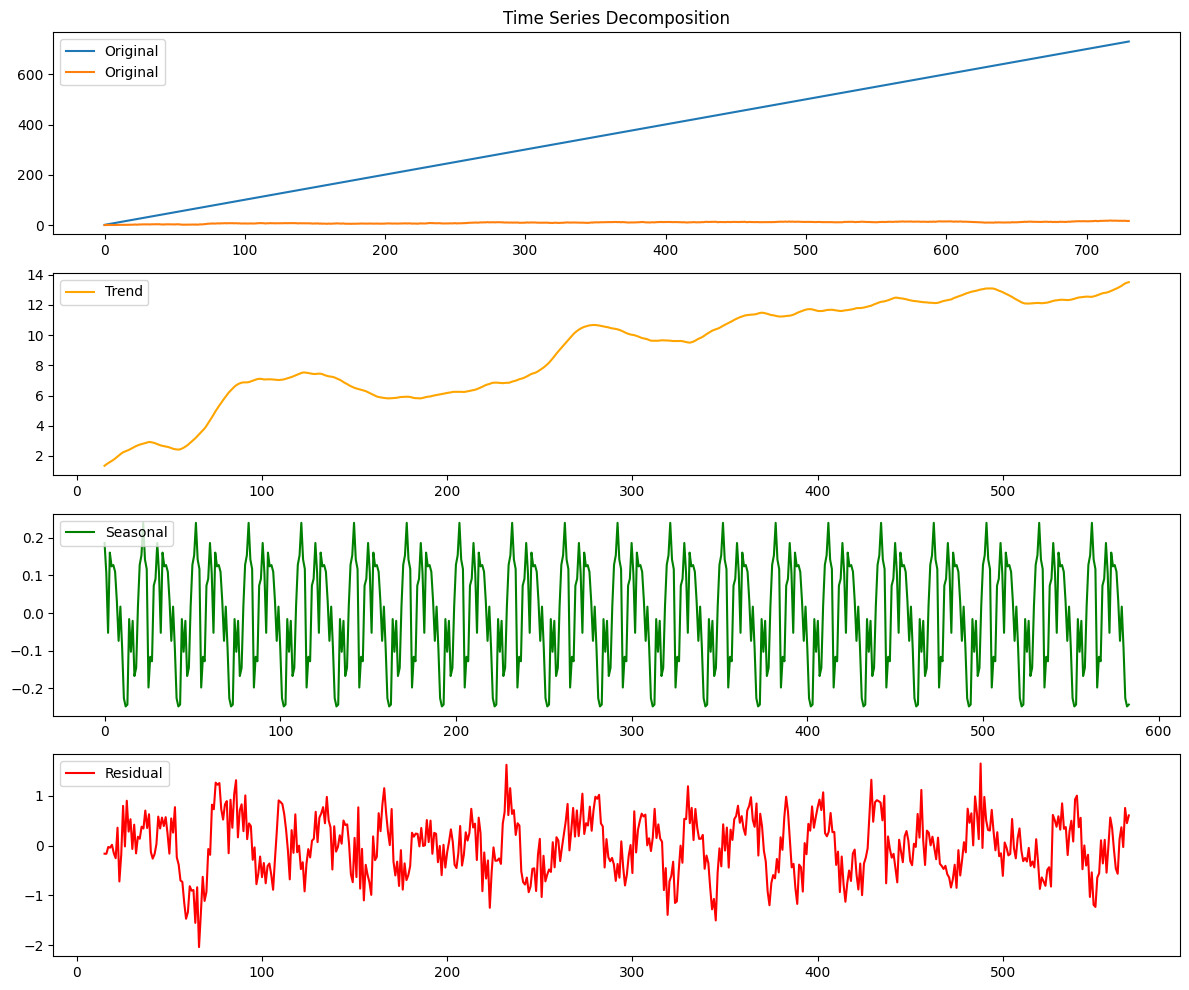

In [18]:
# Decompose the time series


decomposition = seasonal_decompose(train_data['Revenue'], model='additive', period=30)

# Plot the decomposed components
plt.figure(figsize=(12, 10))

# Original series
plt.subplot(4, 1, 1)
plt.plot(df, label='Original')
plt.legend(loc='upper left')
plt.title('Time Series Decomposition')

# Trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

# Residual
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


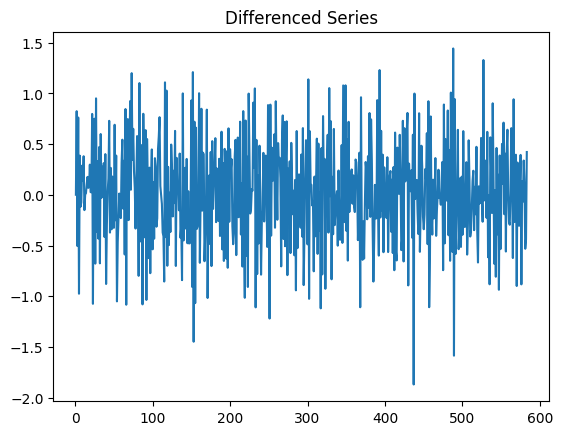

Total missing values:  1
1



0      0.000000
1      0.000792
2      0.824749
3     -0.505210
4      0.762222
         ...   
579    0.338037
580    0.113264
581   -0.531705
582   -0.437835
583    0.422243
Name: diff, Length: 584, dtype: float64

In [19]:
# ARIMA Modeling 

# Apply differencing since the series is non-stationary
train_data['diff'] = train_data['Revenue'].diff()
diff_data = train_data['diff']
diff_data.plot()
plt.title('Differenced Series')
plt.show()

def adf_test(timeseries):
    result = adfuller(timeseries, autolag="AIC")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

#train_data.dropna(inplace=True)
# Missing values
total_missing_values = diff_data.isna().sum().sum()
print('Total missing values: ', total_missing_values)
print(diff_data.isna().sum())
print("")
#adf_test(diff_data)
diff_data[0] = 0
diff_data



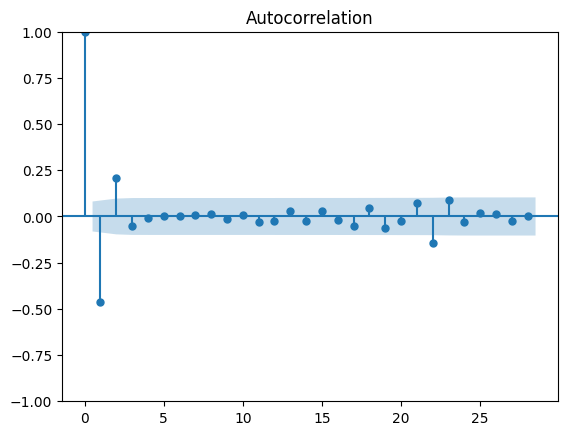

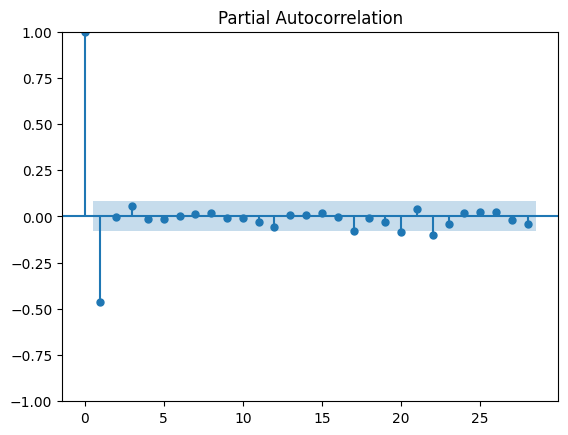

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_data)
plt.show()
plot_pacf(diff_data)
plt.show()


In [21]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

# Test original series
test_stationarity(df['Revenue'])

# If non-stationary, apply differencing
test_stationarity(diff_data)


ADF Statistic: -1.9246120613761046
p-value: 0.32057285950231795
ADF Statistic: -39.674424399702964
p-value: 0.0


In [23]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

best_aic = float("inf")
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(diff_data,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
            print(f'ARIMA{param}x{param_seasonal}30 - AIC:{results.aic}')
        except:
            continue

print(f'Best SARIMA{best_params[0]}x{best_params[1]}30 model - AIC:{best_aic}')


ARIMA(0, 0, 0)x(0, 0, 0, 30)30 - AIC:909.2756451801868
ARIMA(0, 0, 0)x(0, 0, 1, 30)30 - AIC:867.1767068181
ARIMA(0, 0, 0)x(0, 1, 0, 30)30 - AIC:1270.045496964625
ARIMA(0, 0, 0)x(0, 1, 1, 30)30 - AIC:883.9398127424272
ARIMA(0, 0, 0)x(1, 0, 0, 30)30 - AIC:867.8743052553764
ARIMA(0, 0, 0)x(1, 0, 1, 30)30 - AIC:867.5101877340996
ARIMA(0, 0, 0)x(1, 1, 0, 30)30 - AIC:1054.3929852369847
ARIMA(0, 0, 0)x(1, 1, 1, 30)30 - AIC:902.4736468639214
ARIMA(0, 0, 1)x(0, 0, 0, 30)30 - AIC:799.7771439398167
ARIMA(0, 0, 1)x(0, 0, 1, 30)30 - AIC:767.1670204290865
ARIMA(0, 0, 1)x(0, 1, 0, 30)30 - AIC:1164.1413458011364
ARIMA(0, 0, 1)x(0, 1, 1, 30)30 - AIC:773.5746551053894
ARIMA(0, 0, 1)x(1, 0, 0, 30)30 - AIC:768.3390854464428
ARIMA(0, 0, 1)x(1, 0, 1, 30)30 - AIC:766.6948934078985
ARIMA(0, 0, 1)x(1, 1, 0, 30)30 - AIC:952.2481408237254
ARIMA(0, 0, 1)x(1, 1, 1, 30)30 - AIC:795.1967685501261
ARIMA(0, 1, 0)x(0, 0, 0, 30)30 - AIC:1531.393930479102
ARIMA(0, 1, 0)x(0, 0, 1, 30)30 - AIC:1453.3734618166773
ARIMA(0, 1

                                     SARIMAX Results                                      
Dep. Variable:                               diff   No. Observations:                  584
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 30)   Log Likelihood                -368.752
Date:                            Mon, 27 Jan 2025   AIC                            743.504
Time:                                    18:02:16   BIC                            756.450
Sample:                                         0   HQIC                           748.562
                                            - 584                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4501      0.037    -12.002      0.000      -0.524      -0.377
ar.S.L30      -0.0316      0.043   

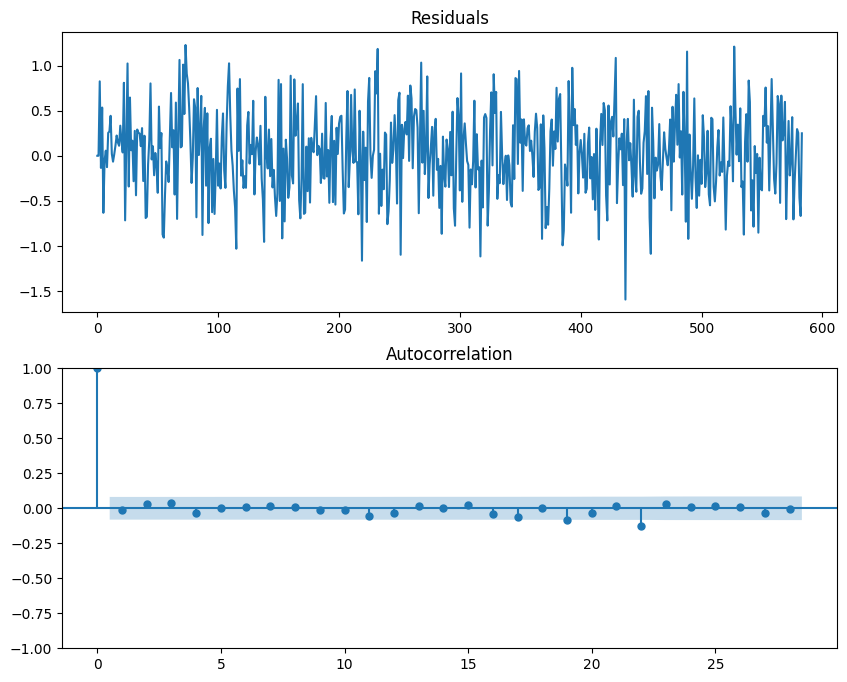

In [24]:
best_model = SARIMAX(diff_data,
                     order=best_params[0],
                     seasonal_order=best_params[1],
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()

print(best_model.summary())

# Residual analysis
residuals = best_model.resid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
residuals.plot(ax=ax1)
ax1.set_title('Residuals')
plot_acf(residuals, ax=ax2)
plt.show()


In [39]:
model = SARIMAX(diff_data, order=(1, 0, 0), seasonal_order=(1, 0, 0, 30))
results = model.fit()

# Assuming 'results' is your fitted SARIMA model
forecast = results.get_forecast(steps=len(test_data['Revenue']))
means = forecast.predicted_mean

means
forecast_values = means + train_data['Revenue'].iloc[-1]

frame = pd.DataFrame({'Actual': test_data['Revenue'], 'Forecasted': forecast_values})
frame

,Actual,Forecasted
584,13.684826,13.307467
585,13.152903,13.585323
586,13.310290,13.479654
587,12.665601,13.511134
588,13.660658,13.476035
...,...,...
726,16.931559,13.504886
727,17.490666,13.504886
728,16.803638,13.504886
729,16.194813,13.504886


In [36]:



mse = mean_squared_error(test_data['Revenue'], forecast_values)
print(f"THe mean squared error for this model is {mse}")


THe mean squared error for this model is 4.683566732801948


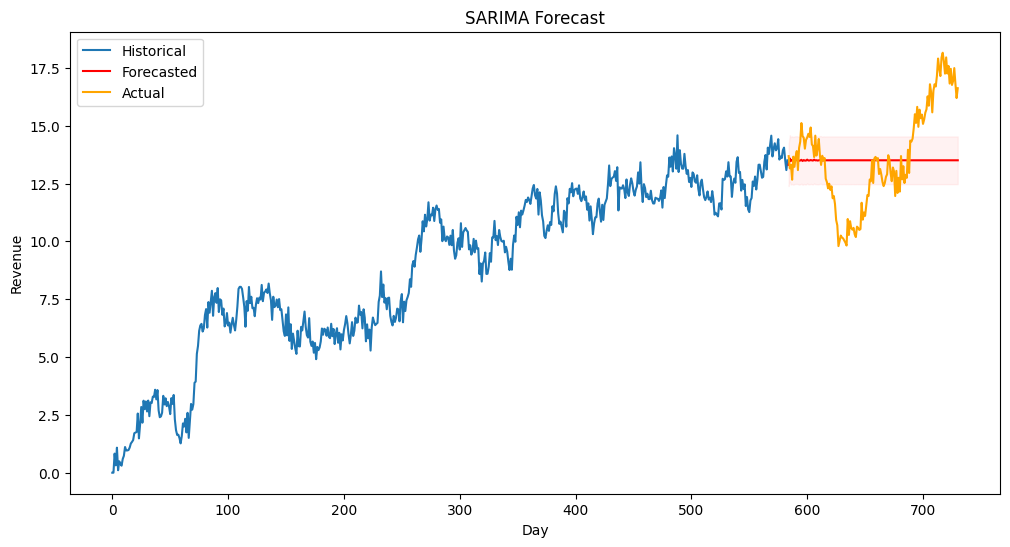

In [40]:

plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(train_data['Revenue'].index, train_data['Revenue'], label='Historical')

# Plot forecast
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecasted')
#plt.plot(rolling_mean, label='Rolling Mean (Trend)', color='orange', linewidth=2)

plt.plot(test_data['Revenue'].index, test_data['Revenue'], label='Actual', color='orange')
confidence_intervals = forecast.conf_int() + train_data['Revenue'].iloc[-1]

# Plot confidence interval
plt.fill_between(confidence_intervals.index, 
                confidence_intervals.iloc[:, 0], 
                confidence_intervals.iloc[:, 1], 
                color='red', alpha=0.05)


plt.title('SARIMA Forecast')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend()
plt.show()

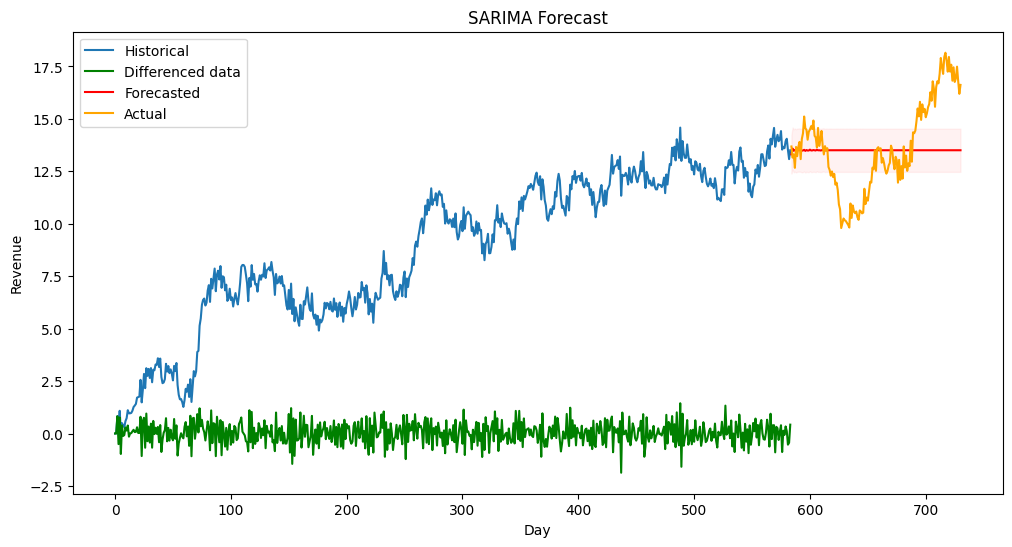

In [42]:
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(train_data['Revenue'].index, train_data['Revenue'], label='Historical')

# Plot differenced data
plt.plot(diff_data.index, diff_data, label='Differenced data', color='green')
# Plot forecast
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecasted')
#plt.plot(rolling_mean, label='Rolling Mean (Trend)', color='orange', linewidth=2)

plt.plot(test_data['Revenue'].index, test_data['Revenue'], label='Actual', color='orange')
confidence_intervals = forecast.conf_int() + train_data['Revenue'].iloc[-1]

# Plot confidence interval
plt.fill_between(confidence_intervals.index, 
                confidence_intervals.iloc[:, 0], 
                confidence_intervals.iloc[:, 1], 
                color='red', alpha=0.05)


plt.title('SARIMA Forecast')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend()
plt.show()